### This notebook is meant to run on a GPU! 
- This example demonstrates the benefit of running streamsculptor on gpu.
We will generate simulations of streams + a subhalo in batches of 700, evaluating the likelihood for each. On a A100 GPU each batch of likelihood evaluations takes ~10 seconds.

- We will implement gradient ascent of the log-likelihood function, and simple Langevin sampling of the posterior distribution for
a subhalo impact. 

- These examples can be extended to other streams, or for a more detailed analysis of GD-1.

In [ ]:
from gala.units import UnitSystem
from astropy import units as u
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)
import jax.numpy as jnp
from astropy.coordinates import SkyCoord, Galactocentric


import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np

from streamsculptor import potential
from streamsculptor import JaxCoords as jc

import interpax

from astropy.constants import G
import diffrax

from streamsculptor import JaxCoords as jc
import tqdm

import matplotlib as mpl
from jax.scipy.stats import gaussian_kde

## Some plotting things (not necessary)
import scienceplots
plt.style.use('science')
mpl.rcParams['text.usetex'] = False ## We do not have LaTex on the HPC...



In [2]:
print(jax.devices()) # CudaDevice = GPU

[CudaDevice(id=0)]


In [3]:
from astropy.table import Table
### load in data from Starkman+2024 (you will need to change this directory to your own file location!)
table = Table.read('gd1_membership_likelhoods_init.ecsv', format='ascii.ecsv')
### Cut at 75% or greater membership probability
gd1_table = table[table['allstream (MLE)']>=0.75]
ra_rad, dec_rad = jnp.deg2rad(gd1_table['coord'].ra.value), jnp.deg2rad(gd1_table['coord'].dec.value)


In [4]:
@jax.jit
def icrs_to_gd1(ra_rad, dec_rad):
    """
    define a *differentiable* coordinate transfrom from ra and dec --> gd1 phi1, phi2
    Using the rotation matrix from Koposov+2010
    ra_rad: icrs ra [radians]
    dec_red: icrs dec [radians]
    """
    R = jnp.array(
        [
            [-0.4776303088, -0.1738432154, 0.8611897727],
            [0.510844589, -0.8524449229, 0.111245042],
            [0.7147776536, 0.4930681392, 0.4959603976],
        ]
    )


    icrs_vec = jnp.vstack([jnp.cos(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(ra_rad)*jnp.cos(dec_rad),
                           jnp.sin(dec_rad)]).T

    stream_frame_vec = jnp.einsum('ij,kj->ki',R,icrs_vec)
    
    phi1 = jnp.arctan2(stream_frame_vec[:,1],stream_frame_vec[:,0])*180/jnp.pi
    phi2 = jnp.arcsin(stream_frame_vec[:,2])*180/jnp.pi

    
    return phi1, phi2

phi1, phi2 = icrs_to_gd1(ra_rad, dec_rad)


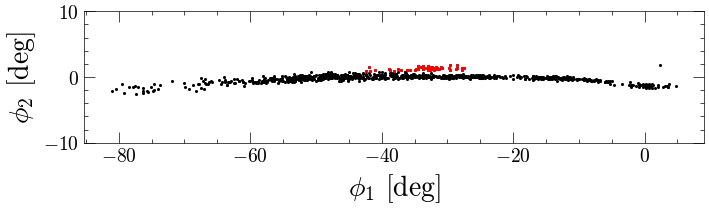

In [5]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(phi1, phi2,s=1.5,color='k')

## Select some spur stars that we will upweight in the likelihood function
phi2_select_thresh = .85
spur_bool = (phi2 > phi2_select_thresh) & (phi1 < 0.)
ax.scatter(phi1[spur_bool], phi2[spur_bool],s=1.5,color='r')


ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

In [7]:
## Estimated progenitor location today in [kpc, kpc, kpc, kpc/Myr, kpc/Myr, kpc/Myr]
## Estimated in a seperate file, but will provide a good starting point for this notebook
## This file can be found in the data folder of the streamsculptor repository:
## data/GD1_prog/GD1_progenitor.npy
prog_wtoday = jnp.load('GD1_progenitor.npy',allow_pickle=True).item()
pos = prog_wtoday.pos.xyz.to(u.kpc).value
vel = prog_wtoday.vel.d_xyz.to(u.kpc/u.Myr).value
prog_wtoday = jnp.hstack([pos,vel])


In [8]:
## Use Gala's MW potential
pot = potential.GalaMilkyWayPotential(units=usys)
## Define the age of the stream [Myr]
t_age = 2500.0
## Past time at which it dissolved [Myr]
t_dissolve = -300.0
## Get initial conditions
IC = pot.integrate_orbit(w0=prog_wtoday, t0=0.0, t1=-t_age,ts=jnp.array([-t_age])).ys[0]
## Define stripping times. ts[-1] is always the final integration time for gen_stream simulations
ts = jnp.hstack([jnp.linspace(-t_age,t_dissolve,2_000), jnp.array([0.0])])
## Generate unperturbed stream [l: lead, t: trail]
l ,t = pot.gen_stream_vmapped(prog_w0=IC,ts=ts,seed_num=532,Msat=1e4,atol=1e-6,rtol=1e-6,solver=diffrax.Dopri5())
stream = jnp.vstack([l,t])

In [9]:
@jax.jit
def get_phi12_from_stream(stream):
    """
    Differentiable helper function that takes us from simulated stream --> phi1, phi2
    """
    ra_s, dec_s, dist_ = jax.vmap(jc.simcart_to_icrs)(stream[:,:3])
    phi1_model, phi2_model = icrs_to_gd1(ra_s*jnp.pi/180, dec_s*jnp.pi/180)
    return phi1_model, phi2_model

phi1_model, phi2_model = get_phi12_from_stream(stream[:,:3])

    

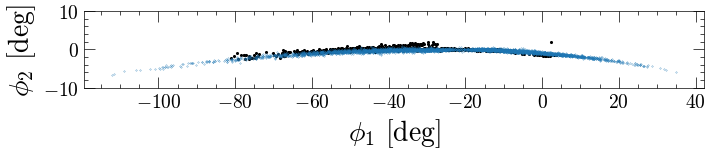

In [10]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(phi1, phi2,s=1.5,color='k')
ax.scatter(phi1_model, phi2_model,s=.05,color='tab:blue')

    
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

#### Now for the likelihood. We will use the approach from Adrian Price-Whelan, outlined here: https://adrian.pw/blog/flexible-density-model-jax/

In summary, we will model the data as an inhomogenous poisson process. We proceed in 3 steps:
1. Generate a model stream with a subhalo impmact at parameters $\theta$.
2. Fit a smooth kde to the model stream in ($\phi_1, \phi_2$) coordinates. 
3. Evaluate the log-likelihood of the data using the model kde.
------------------------------------------------------------------------------------
#### A bit more detail:

Let $p(\phi_1, \phi_2 | \theta)$ represent the kde of the model at parameters $\theta$.

The $i^{th}$ data point is $d_i = (\phi_{1,d}^{(i)},\phi_{2,d}^{(i)})$. There are $N_{\rm data}$ data points, and $N_{\rm model}$ model points in the $\phi_1 - \phi_2$ box that we will define. 

The likelihood is
### $$\mathcal{L}( \{d_i\} | \theta ) = e^{-\int_\Omega N_{\rm model} p(\phi_1, \phi_2 | \theta) d\phi_1 d\phi_2} \prod_{i=1}^{N_{\rm data}} N_{\rm model} p(d_i | \theta ).$$

Note we have renormalized the kdes to a _number density_, since we are modeling the number density of the data. The integrate of the kde is just 1, so we are left with a log-likelihood as follows:

### $$\log\left(\mathcal{L}( \{d_i\} | \theta ) \right) = -N_{\rm model} + N_{\rm data}\log(N_{\rm model}) + \sum_{i=1}^{N_{\rm data}}  \log\left(p(d_i | \theta )\right).$$

And that's it! Welll, almost. If you try maximizing this log-likelihood with many simulations, you will likely find that the spur is not prominent enough in the dataset (the one we use here at least) to reliably be captured by the optimized model. That is, the increase in likelihood with a prominent spur versus without one is small, since there are so many more stream data points than spur data points. To emphasize the spur, we will do something hacky and utilize a weighted log-likelihood:


### $$\log\left(\mathcal{L}( \{d_i\} | \theta ) \right) = -N_{\rm model} + N_{\rm data}\log(N_{\rm model}) + \sum_{i=1}^{N_{\rm data}} w_i \log\left(p(d_i | \theta )\right).$$

The weights $w_i$ are importance weights for each data point. For spur stars we'll use somehthing like $w_i =1.5$, and $w_i = 1$ for all other stars. Essentially we're upsampling the spur in the likelihood. Weighted likelihoods are not unusual, and typically come into play when needing to capture the lower probability tails of a distribution. That is the scenario we are dealing with here, since $N_{\rm spur} << N_{\rm main \ stream}$.


In [11]:
## We're just going to use the data between phi1 of -60 and -20
## This helps us hone in on the spur, and defines the domain of the integral (Omega) above
phi1_min = -60.
phi1_max = -20.
@jax.jit
def log_like_provided_data_model(phi1_data=None, phi2_data=None, phi1_model=None, phi2_model=None,phi1_min=phi1_min, phi1_max=phi1_max, phi2_min=-10.,phi2_max=10.0,bw=0.15,
                                spur_ids=None):
    inp_data = jnp.vstack([phi1_data, phi2_data])
    inp_model = jnp.vstack([phi1_model, phi2_model])
    ## Weights for the kde: start with uniform
    weights = jnp.ones_like(phi1_model)
    ## Check where the model is outside of the domain (Omega)
    pred = (phi1_model < phi1_min) | (phi1_model > phi1_max) | (phi2_model < phi2_min) | (phi2_model > phi2_max)
    ## wherever the model is outsize of the domain, set the weights to zero.
    ## This way the model has no support outside of the domain
    weights = jnp.where( pred, 0.0, weights)
    ## N0 = N_model here
    N0 = jnp.sum(weights)
    weights = weights/weights.sum()
    ## Fit the kde
    kde = gaussian_kde(inp_model,bw_method=bw, weights=weights)
    ## N = N_data
    N = len(phi1_data)
    logpdf = kde.logpdf(inp_data)
    ## Next we define the w_i's, or the importance weights below
    ## Generate id list of importance weights
    importance_weights_idx = jnp.arange(len(phi1_data))
    ## Check if importance weights are in spur_ids. If they are, assign a value of 1.5. Otherwise, 1.
    importance_weights = jnp.where(jnp.isin(importance_weights_idx,spur_ids),1.5,1.) 
    
    return  -N0 + N*jnp.log(N0) + jnp.sum(logpdf*importance_weights)

## Bool for where data is in the domain (Omega)
data_in_bool = (phi1 > phi1_min) & (phi1< phi1_max)

spur_in_bool = spur_bool[data_in_bool]
spur_ids = jnp.where(spur_in_bool==True)[0]

In [12]:
# test the log-likelihood
test_like = log_like_provided_data_model(phi1_model=phi1_model, phi2_model=phi2_model, phi1_data=phi1[data_in_bool], phi2_data=phi2[data_in_bool],
                                       spur_ids=spur_ids)
print(test_like)

-5569.410611355764


In [13]:
def plot_kde(phi1_data=None, phi2_data=None, phi1_model=None, phi2_model=None,phi1_min=phi1_min, phi1_max=phi1_max, phi2_min=-10.,phi2_max=10.0,bw=0.1):
    inp_data = jnp.vstack([phi1_data, phi2_data])
    inp_model = jnp.vstack([phi1_model, phi2_model])
    weights = jnp.ones_like(phi1_model)
    pred = (phi1_model < phi1_min) | (phi1_model > phi1_max) | (phi2_model < phi2_min) | (phi2_model > phi2_max)
    weights = jnp.where( pred, 0.0, weights)
    kde = gaussian_kde(inp_model,bw_method=bw, weights=weights)
    xlin = jnp.linspace(-100,40,150)
    ylin = jnp.linspace(-10,10,151)
    X,Y = jnp.meshgrid(xlin,ylin)
    inp_eval = jnp.vstack([X.flatten(),Y.flatten()])
    return X, Y, kde.pdf(inp_eval).reshape(X.shape)
        
        
        
        

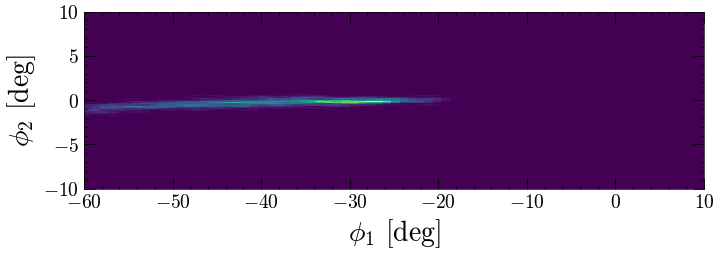

In [14]:
out_plot = plot_kde(phi1_model=phi1_model, phi2_model=phi2_model, phi1_data=phi1[data_in_bool], phi2_data=phi2[data_in_bool])

####
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
#ax.scatter(phi1_model, phi2_model,s=.05,color='tab:blue')

ax.pcolormesh(out_plot[0],out_plot[1],out_plot[2])

#ax.scatter(phi1, phi2,s=1.5,color='k')

ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-60,10)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

In [15]:
## import the impact generator, for generator parameters for subhalo impacts
from streamsculptor.GenerateImpactParams import ImpactGenerator
ImpactGen = ImpactGenerator(pot=pot, tobs=0.0, stream=stream, stream_phi1=phi1_model, phi1_bounds=[phi1_min,phi1_max],
                           tImpactBounds=[-2500,0.0],phi1window=.8)


In [16]:
## Import the stream generator (vmap, because we're using a GPU)
from streamsculptor import gen_stream_vmapped_with_pert


In [17]:
## Now we're going to import a differentiable spline function.
## We will fit this spline to the unperturbed stream in phase-space, such that we can
## evaluate x(phi1), y(phi1), ... etc.
import interpax

def get_cart_spline(phi1, stream):
    spl_funcs = []
    for i in range(6):
        spl_funcs.append(interpax.Interpolator1D(x=phi1,f=stream[:,i],method='cubic2'))
    return spl_funcs
def eval_splines(phi1_eval, splines):
    output = jnp.zeros(6)
    for i in range(6):
        output = output.at[i].set(splines[i](phi1_eval))
    return output


args_phi1 = jnp.argsort(phi1_model)
splines = get_cart_spline(phi1_model[args_phi1], stream[args_phi1,:])
eval_mean = lambda phi1_eval:eval_splines(phi1_eval,splines)
eval_mean = jax.jit(eval_mean)

## Example: get the mean phase-space coord at phi1 of -30:
print('example 1: ' +str(eval_mean(-30.0)))

## Example: get the gradient of the mean phase-space coord wrspct to phi1, at phi1 of -30
print('example 2: ' +str(jax.jacfwd(eval_mean)(-30.0)))


example 1: [-12.19942006   0.4483408    6.52725897  -0.07686926  -0.2278697
  -0.1179158 ]
example 2: [-1.82124843  0.99460869  0.46868141  0.09943612  0.01698883  0.01304511]


In [18]:
## Some functions to generate the perturbed stream.
## There are more clean ways to do this using ImpactGen,
## but the default function to take phi1 --> mean phase-space coord is not differentiable.
## This will be changed in the future.
@jax.jit
def get_subhalo_params_cart(sampled_params):
    
    stream_mean = eval_mean(sampled_params['phi1_0'])  
    XV_Impact, __ = ImpactGen._get_subhalo_ImpactParamsCartesian(tobs=0.0,particle_mean=stream_mean, tImpact=-10**sampled_params['log10_tImpact'],
                                                bImpact=10**sampled_params['log10_bImpact'], vImpact=sampled_params['vImpact'],
                                                phi=sampled_params['phi'], beta=sampled_params['beta'],
                                                gamma=sampled_params['gamma'])
    
    
    return XV_Impact

@jax.jit
def gen_perturbed_stream(total_param_dict):
    """
    subhalo_params is a dictionary containing Cartesian information for the subhalo impact
    """
    XV_Impact = get_subhalo_params_cart(total_param_dict)
    
    pot_SH = potential.SubhaloLinePotential(m=jnp.array([10**total_param_dict['log10_m']]), a=jnp.array([10**total_param_dict['log10_a']]),
                                            subhalo_x0=jnp.array([XV_Impact[:3]]),
                                            subhalo_v=jnp.array([XV_Impact[3:]]),
                                            subhalo_t0=jnp.array([-10**total_param_dict['log10_tImpact']]),
                                            t_window=jnp.array([100.0]),
                                            units=usys)
    
    pot_lst = [pot, pot_SH]
    pot_total = potential.Potential_Combine(pot_lst,units=usys)
    
    IC = pot_total.integrate_orbit(w0=prog_wtoday, t0=0.0, t1=-t_age,ts=jnp.array([-t_age]),max_steps=10_000).ys[0]
    l ,t = gen_stream_vmapped_with_pert(pot_base=pot, pot_pert=pot_SH, prog_w0=IC, ts=ts, seed_num=532, Msat=1e4, max_steps=10_000,
                                        atol=1e-6,rtol=1e-6, solver=diffrax.Dopri5(), dtmin=0.05)
    stream = jnp.vstack([l,t])

    return stream




In [19]:
## Test dictionary with parameter inputs
test_dict = dict(phi1_0=-50.0, log10_tImpact=jnp.log10(800.0), log10_bImpact=-3., vImpact=.15, phi=.2,beta=.1,gamma=0.01,log10_m=7.2,log10_a=jnp.log10(.05))
## output the cartesian parameters of the subhalo at impact:
get_subhalo_params_cart(test_dict)

Array([ 9.77228536, -5.77300377, -9.42727807,  0.0455144 ,  0.13927406,
        0.03211191], dtype=float64)

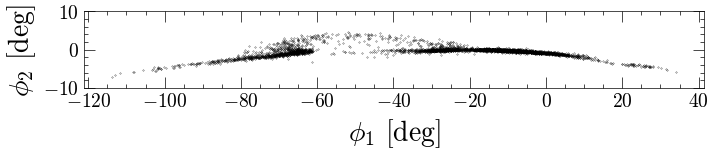

In [20]:
## Example perturbed stream
test_stream = gen_perturbed_stream(test_dict)
p1_test, p2_test = get_phi12_from_stream(test_stream[:,:3])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(p1_test, p2_test,s=0.05,color='k')
    
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

In [21]:
@jax.jit
def ln_likelihood(param_dict):
    """
    ln_likelihood function that takes only a parameter dictionary as input
    """
    stream_out = gen_perturbed_stream(param_dict)
    phi1_model, phi2_model = get_phi12_from_stream(stream_out[:,:3])
    log_like = log_like_provided_data_model(phi1_model=phi1_model, phi2_model=phi2_model, phi1_data=phi1[data_in_bool], 
                                            phi2_data=phi2[data_in_bool],spur_ids=spur_ids,bw=.15)
    return log_like




In [22]:
## We will create a batched (or mapped) likelihood evaluation function.
## This function takes in a param dict, where each key has an array of values 
## corresponding to each simulation. 
## We will run the simulations using jax vectorization. 
## I.e., we can run ~600 simulations in around 10 seconds using vmap's internal
## optimizations and parallelization on gpu
map_dict = {}
for key in test_dict:
    map_dict[key] = 0

print(map_dict)
mapped_ln_like = jax.jit(jax.vmap(ln_likelihood,in_axes=(map_dict,)))

{'phi1_0': 0, 'log10_tImpact': 0, 'log10_bImpact': 0, 'vImpact': 0, 'phi': 0, 'beta': 0, 'gamma': 0, 'log10_m': 0, 'log10_a': 0}


### Next we will sample thousands of subhalo impacts + simulations from a prior, identify a best fit, and perform gradient ascent around the best fit for further optimization.

In [23]:
def sample_prior(seed=None, n_samp=None):
    key = jax.random.PRNGKey(seed)
    
    log10_m = jax.random.uniform(key, (n_samp,), minval=6.0, maxval=7.0)
    key, subkey = jax.random.split(key)
    log10_a = jax.random.uniform(subkey, (n_samp,), minval=jnp.log10(0.01), maxval=jnp.log10(0.2))
    key, subkey = jax.random.split(key)
    phi1_0 = jax.random.uniform(subkey, (n_samp,), minval=-60.0, maxval=-10.0)
    key, subkey = jax.random.split(key)
    log10_tImpact = jax.random.uniform(subkey, (n_samp,), minval=1, maxval=jnp.log10(2_000))
    key, subkey = jax.random.split(key)
    log10_bImpact = jax.random.uniform(subkey, (n_samp,), minval=-5, maxval=jnp.log10(0.5))
    key, subkey = jax.random.split(key)
    vImpact = jax.random.uniform(subkey, (n_samp,), minval=-0.4, maxval=0.4)
    key, subkey = jax.random.split(key)
    phi = jax.random.uniform(subkey, (n_samp,), minval=0.0, maxval=jnp.pi)
    key, subkey = jax.random.split(key)
    beta = jax.random.uniform(subkey, (n_samp,), minval=0.0, maxval=jnp.pi/2)
    key, subkey = jax.random.split(key)
    gamma = jax.random.uniform(subkey, (n_samp,), minval=0.0, maxval=jnp.pi/2)
    return {
        'log10_m': log10_m,
        'log10_a': log10_a,
        'phi1_0': phi1_0,
        'log10_tImpact': log10_tImpact,
        'log10_bImpact': log10_bImpact,
        'vImpact': vImpact,
        'phi': phi,
        'beta': beta,
        'gamma': gamma,
   
    }


In [24]:
## Sample batches of simulations
def batch_simulation(seed, n_batch, n_total_batch):
    key = jax.random.PRNGKey(seed)
    all_samples = []
    all_likelihoods = []
    count = 0 
    for _ in tqdm.tqdm(range(n_total_batch)):
        
        priors = sample_prior(seed + count, n_batch)
        count+=1
        
        # Evaluate log-likelihoods for all samples
        log_likes = mapped_ln_like(priors)
        
        for i in range(n_batch):
            sample = {k: v[i] for k, v in priors.items()}
            all_samples.append(sample)
            all_likelihoods.append(log_likes[i])
    
    return all_samples, all_likelihoods

### Caution: you should run the cell below on a gpu.
#### Runtime on a A100 gpu, 40 batches of 700 simulations is around 7 minutes 30 seconds

In [25]:
### I have  cell runs on a A100 GPU

seed = 8942
# Number of simulations to run in one iteration
n_batch = 700
# How many iterations we are running total
n_total_batch = 40
print('total number of simulations being run: ' + str(n_batch*n_total_batch))
samples, likelihoods = batch_simulation(seed, n_batch, n_total_batch)


total number of simulations being run: 28000


100%|██████████| 40/40 [07:31<00:00, 11.30s/it]


In [28]:
## transform to array and visualize best fit below

ll = jnp.asarray(likelihoods)


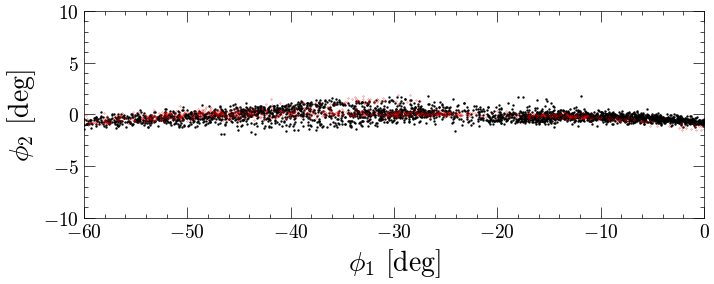

In [30]:
best_fit = samples[jnp.argmax(ll)] 

### Visualize the best fit of the 28000 runs
test_stream = gen_perturbed_stream(best_fit)
p1_test, p2_test = get_phi12_from_stream(test_stream[:,:3])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(p1_test, p2_test,s=0.5,color='k')
ax.scatter(phi1, phi2,s=0.05,color='r')

ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-60,0)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

#### Okay not bad for brute force sampling from the prior! This is luck of the draw, but the above simulation was obtain from 28000 runs.

#### Next, let's refine this parameter draw by optimizing the likelihood with gradient ascent (ascent, because we will be ascending the likelihood landscape). 

The algorithm we will follow is
$$ \theta \xrightarrow{} \theta + \lambda \nabla_\theta \log(\mathcal{L}(\{d_i\}|\theta),$$
where $\lambda$ is the "learning rate", and controls the step size.

In [42]:
### Gradient of ln-likelihood is simple as
grad_func = jax.jit(jax.jacfwd(ln_likelihood))

def gradient_ascent(params, learning_rates, num_iterations):
    trajectory = []
    loglike = []
    for i in range(num_iterations):
        grads = grad_func(params)
        params = {k: v + learning_rates[k] * grads[k] for k, v in params.items()}
        ll = ln_likelihood(params)
        trajectory.append(params)
        loglike.append(ll)
        if i % 5 == 0:  # Print progress every 10 iterations
            arr = jnp.asarray(loglike)
            print(f"Iteration {i}, max lnlikelihood {str(arr.max())}")
    return params, trajectory, loglike


In [43]:
## Gradient of ln-likelihood at the best fit
## *first compile will take awhile* Subsequent runs are faster.
print(grad_func(best_fit)) 

{'beta': Array(439.42649615, dtype=float64), 'gamma': Array(712.62780826, dtype=float64), 'log10_a': Array(-334.57563649, dtype=float64), 'log10_bImpact': Array(2.59775137, dtype=float64), 'log10_m': Array(411.90750985, dtype=float64), 'log10_tImpact': Array(-3585.90946228, dtype=float64), 'phi': Array(0.04290404, dtype=float64), 'phi1_0': Array(-32824.70773611, dtype=float64), 'vImpact': Array(-1530.87014143, dtype=float64)}


In [44]:
lr = 1e-10 
learning_rates = {
    'log10_m': lr,
    'log10_a': lr,
    'phi1_0': lr,
    'log10_tImpact': lr,
    'log10_bImpact': lr,
    'vImpact': lr,
    'phi': lr,
    'beta': lr,
    'gamma': lr
}


In [45]:
nsteps = 20
params_final, traj, loglike_traj = gradient_ascent(best_fit,learning_rates,nsteps) 

Iteration 0, max lnlikelihood 262.00098165050986
Iteration 5, max lnlikelihood 263.0048934197912
Iteration 10, max lnlikelihood 265.20699335056315
Iteration 15, max lnlikelihood 265.20699335056315


In [46]:
loglike_traj = jnp.asarray(loglike_traj)
id_max = jnp.argmax(loglike_traj)
params_MLE = traj[id_max]

In [50]:
print('Original lnL, Improved lnL: ' + str(ln_likelihood(best_fit))+','+str(
                                          ln_likelihood(params_MLE))
                                          )

Original lnL, Improved lnL: 260.3748689953536,265.20699335056315


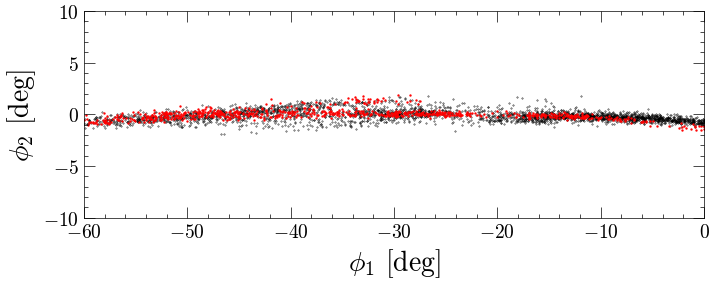

In [51]:
test_stream = gen_perturbed_stream(params_MLE)
p1_test, p2_test = get_phi12_from_stream(test_stream[:,:3])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(p1_test, p2_test,s=0.1,color='k')
ax.scatter(phi1, phi2,s=0.5,color='r')

ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-60,0)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

Finally, let's generate some samples from the posterior in the neighborhood of the MLE we have identified. Note that this is likely a local maximum, but the sampling procedure below can be easily generalized with vmap to sample many local modes.

We will utilize Langevin sampling, which is essentially gradient ascent (or descent) with added noise. The Langevin equation consists of a drift and diffusion term. The drift controls the mean trajectory of the likelihood exploration, while the diffusion term introduces a random-walk-like motion along the likelihood surface.

The equation for Langevin sampling is typically written as:

$$
\theta_{t+1} = \theta_t + \frac{\epsilon}{2} \nabla_{\theta_t} \log p(\theta_t) + \sqrt{\epsilon} \, \xi_t
$$

where:

-  $\theta_t$ is the parameter vector at the \(t\)-th step.
- $\epsilon$ is the step size (or learning rate) controlling the scale of the update.
- $\nabla \log p(\theta_t)$ is the gradient of the log-likelihood at the current position.
- $\xi_t \sim \mathcal{N}(0, I)$ is a random noise term drawn from a standard normal distribution at each step.
- $\sqrt{\epsilon} \, \xi_t$ introduces noise at each step, allowing the sampler to explore the posterior surface.


In [97]:
def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm.tqdm(range(num_samples)):
        grads = grad_func(params)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size * grads[k] + jnp.sqrt(step_size) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [152]:
# Generate a random key
seed = 490
rng_key = jax.random.PRNGKey(seed)
out_samps = langevin_sampler(params_MLE,500,1e-7,rng_key)

100%|██████████| 500/500 [10:22<00:00,  1.24s/it]


In [185]:
samples_array = np.array([[params[k] for k in params_MLE.keys()] for params in out_samps])
param_range = [1. for _ in range(samples_array.shape[1])]


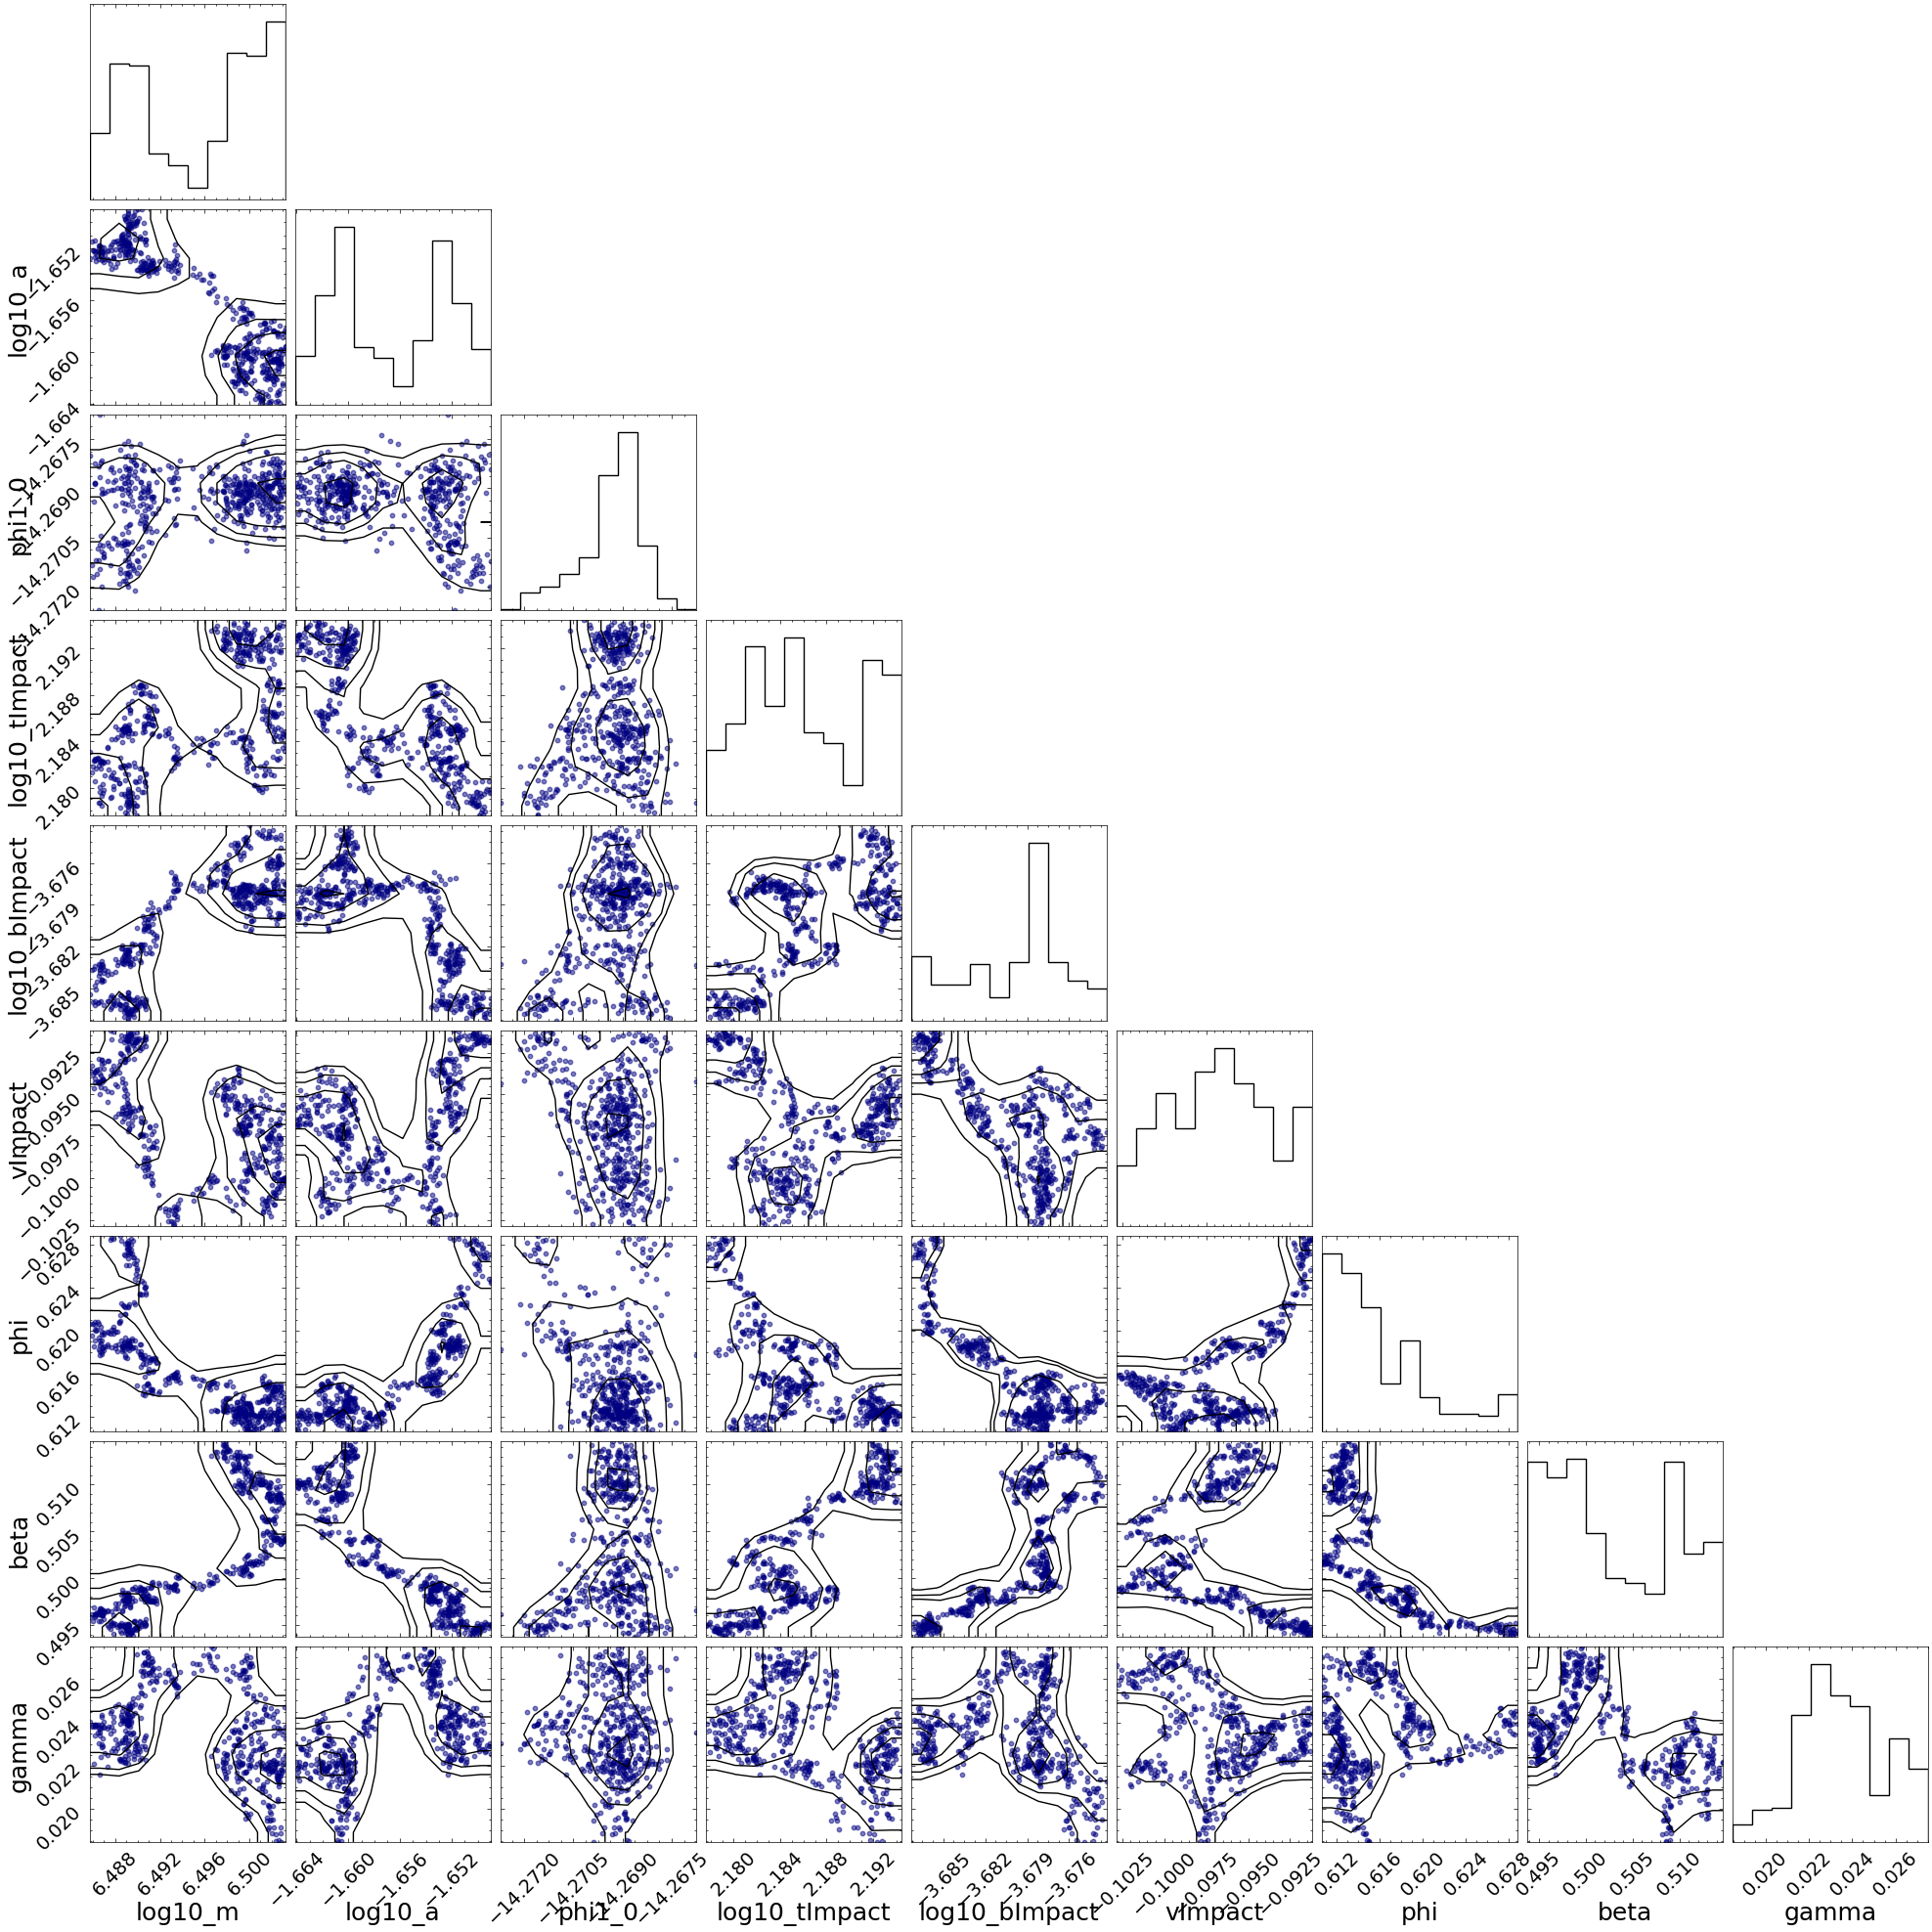

In [186]:
import corner
## Some plotting options
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelsize'] = 16  
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14  

figure = corner.corner(samples_array, labels=list(params_MLE.keys()),bins=10,smooth=1.,
                       plot_datapoints=False,plot_contours=True, plot_density=False,
                       range=param_range,label_kwargs={"fontsize": 18} 
                      )
# Overlay the data points on top of the contours
axes = figure.get_axes()
for i in range(len(param_range)):
    for j in range(i):
        ax = axes[i * len(param_range) + j]
        ax.scatter(samples_array[:, j], samples_array[:, i], s=10, color='navy', alpha=0.5,rasterized=True)



### It seem's like we have identified two local mass modes. Let's plot a sample from the low and high mass mode below. They should produce similar looking streams.

In [193]:
### Let's generate a stream from the two main mass modes (low mass SH and higher mass)
low_mass_bool = samples_array[:,0]<6.493
low_mass_sample_inds = jnp.where(low_mass_bool==True)[0]
high_mass_sample_inds = jnp.where(low_mass_bool==False)[0]

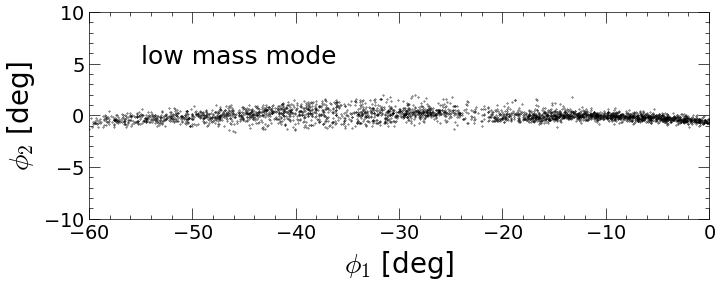

In [212]:
test_stream = gen_perturbed_stream(out_samps[low_mass_sample_inds[28]])
p1_test, p2_test = get_phi12_from_stream(test_stream[:,:3])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(p1_test, p2_test,s=0.1,color='k')
#ax.scatter(phi1, phi2,s=0.5,color='r')
ax.text(-55,5,'low mass mode',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-60,0)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')

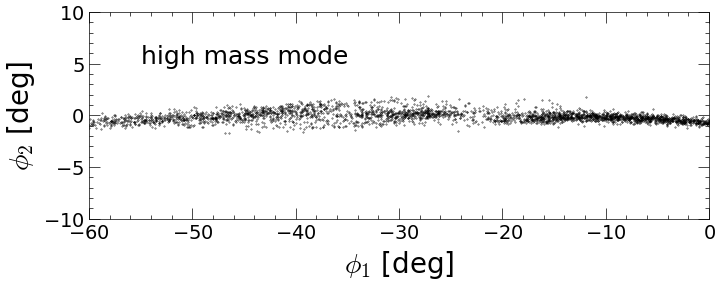

In [213]:
test_stream = gen_perturbed_stream(out_samps[high_mass_sample_inds[28]])
p1_test, p2_test = get_phi12_from_stream(test_stream[:,:3])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.scatter(p1_test, p2_test,s=0.1,color='k')
ax.text(-55,5,'high mass mode',fontsize=18)

#ax.scatter(phi1, phi2,s=0.5,color='r')

ax.tick_params(axis='both', which='major', labelsize=14., length=8)
ax.tick_params(axis='both', which='minor', length=3)
ax.set_ylim(-10,10)
ax.set_xlim(-60,0)
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)
ax.set_aspect('equal')